In [1]:
%matplotlib inline
#%% NumPyの読み込み
import numpy as np
#   NumPyのPolynomialモジュールの読み込み
import numpy.polynomial.polynomial as pol
#   NumPyのLinalgモジュールの読み込み
import numpy.linalg as lin
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
else:
    print('このPythonコードが対応していないOSを使用しています．')
    sys.exit()
jpfont = FontProperties(fname=FontPath)

In [2]:
#%% 債券価格の計算
def Bond_Price(Yield, Maturity, CouponRate, FaceValue):
    #      Yield: 債券利回り (%)
    #   Maturity: 残存期間
    # CouponRate: 表面利率 (%)
    #  FaceValue: 額面
    #     Output: 債券価格
    Coupon = 0.01 * CouponRate * FaceValue
    CF = np.hstack((0.0, np.tile(Coupon, int(Maturity) - 1), FaceValue + Coupon))
    return pol.polyval(1.0 / (1.0 + 0.01 * Yield), CF)

In [3]:
#%% 債券利回りの計算
def Bond_Yield(Price, Maturity, CouponRate, FaceValue):
    #      Price: 債券価格
    #   Maturity: 残存期間
    # CouponRate: 表面利率 (%)
    #  FaceValue: 額面
    #     Output: 債券利回り (%)
    Coupon = 0.01 * CouponRate * FaceValue
    CF = np.hstack((-Price, np.tile(Coupon, int(Maturity) - 1), FaceValue + Coupon))
    Roots = pol.polyroots(CF)
    Real = np.real(Roots[np.isreal(Roots)])
    Positive = (Real[Real > 0.0]).item(0)
    return (1.0 / Positive - 1.0) * 100

In [4]:
#%% 債券の利回りと価格の計算
#   利回り7%，残存期間7年，表面利率5%，額面100円の利付債の価格
P_A = Bond_Price(7, 7, 5, 100)
#   価格98円，残存期間5年，表面利率5%，額面100円の利付債の利回り
Y_B = Bond_Yield(98, 5, 5, 100)

In [5]:
print([P_A, Y_B])

[89.2214211967026, 5.467941206809157]


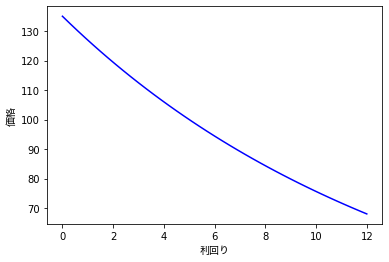

In [6]:
#%% 債券の利回りと価格の関係を示すグラフの作成
#   残存期間7年，表面利率5%，額面100円の利付債
V_Yield = np.linspace(0, 12, 41)
V_Price = np.array([Bond_Price(Yield, 7, 5, 100) for Yield in V_Yield])
fig1 = plt.figure(num=1, facecolor = 'w')
plt.plot(V_Yield, V_Price, 'b-')
plt.xlabel('利回り', fontproperties=jpfont)
plt.ylabel('価格', fontproperties=jpfont)
plt.show()

In [7]:
#%% 債券デュレーションの計算
def Bond_Duration(Yield, Maturity, CouponRate, FaceValue):
    #      Yield: 債券利回り (%)
    #   Maturity: 残存期間
    # CouponRate: 表面利率 (%)
    #  FaceValue: 額面
    #     Output: 債券デュレーション
    Price = Bond_Price(Yield, Maturity, CouponRate, FaceValue)
    Coupon = 0.01 * CouponRate * FaceValue
    CF = np.hstack((np.tile(Coupon, int(Maturity) - 1), Coupon + FaceValue))
    Coef = np.linspace(1, Maturity, Maturity) * CF
    return pol.polyval(1.0 / (1.0 + 0.01 * Yield), np.hstack((0.0, Coef))) / Price

In [8]:
#%% 債券コンベクシティの計算
def Bond_Convexity(Yield, Maturity, CouponRate, FaceValue):
    #      Yield: 債券利回り (%)
    #   Maturity: 残存期間
    # CouponRate: 表面利率 (%)
    #  FaceValue: 額面
    #     Output: 債券コンベクシティ
    Price = Bond_Price(Yield, Maturity, CouponRate, FaceValue)
    Duration = Bond_Duration(Yield, Maturity, CouponRate, FaceValue)
    Coupon = 0.01 * CouponRate * FaceValue
    CF = np.hstack((np.tile(Coupon, int(Maturity) - 1), Coupon + FaceValue))
    Coef = (np.linspace(1, Maturity, Maturity) - Duration)**2 * CF
    Dispersion = pol.polyval(1.0 / (1.0 + 0.01 * Yield), np.hstack((0.0, Coef))) \
                 / Price
    return (Dispersion + (1.0 + Duration) * Duration) / (1.0 + 0.01 * Yield)**2

In [9]:
#%% 債券のデュレーションとコンベクシティの計算
#   債券A: 残存期間10年，表面利率7%，額面100円
#   債券B: 残存期間8年，表面利率0.9%，額面100円
#   利回りは全て5%で統一
P_A = Bond_Price(5, 10, 7, 100)
P_B = Bond_Price(5, 8, 0.9, 100)
D_A = Bond_Duration(5, 10, 7, 100)
D_B = Bond_Duration(5, 8, 0.9, 100)
C_A = Bond_Convexity(5, 10, 7, 100)
C_B = Bond_Convexity(5, 8, 0.9, 100)

In [10]:
print([P_A, P_B, D_A, D_B, C_A, C_B])

[115.4434698583696, 73.50082768635235, 7.705327414925867, 7.7027886687199825, 69.7275539663588, 62.10963633984605]


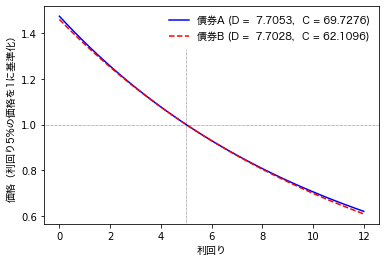

In [11]:
#%% 債券のデュレーションとコンベクシティの関係を示すグラフの作成
V_Yield = np.linspace(0, 12, 41)
V_Price_A = np.array([Bond_Price(Yield, 10, 7, 100) for Yield in V_Yield])
V_Price_B = np.array([Bond_Price(Yield, 8, 0.9, 100) for Yield in V_Yield])
fig3 = plt.figure(num=3, facecolor='w')
plt.plot(V_Yield, V_Price_A / P_A, 'b-')
plt.plot(V_Yield, V_Price_B / P_B, 'r--')
plt.axhline(1, color='k', linestyle=':', linewidth=0.5)
plt.axvline(5, ymin=0, ymax=0.8, color='k', linestyle=':', linewidth=0.5)
plt.xlabel('利回り', fontproperties=jpfont)
plt.ylabel('価格（利回り5%の価格を1に基準化）', fontproperties=jpfont)
Legend_A = '債券A (D ={0:8.4f}，C ={1:8.4f})'.format(D_A, C_A)
Legend_B = '債券B (D ={0:8.4f}，C ={1:8.4f})'.format(D_B, C_B)
plt.legend([Legend_A, Legend_B], loc='best', frameon=False, prop=jpfont)
plt.show()

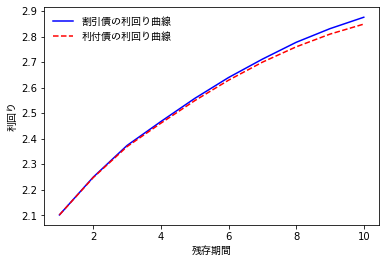

In [12]:
#%% 債券の利回り曲線
#   債券データ: 1列目-市場価格，2列目-残存期間，3列目-表面利率
Bond = np.array([
    [ 99.90,  1, 2.0],
    [100.10,  2, 2.3],
    [100.66,  3, 2.6],
    [ 99.77,  4, 2.4],
    [ 98.38,  5, 2.2],
    [ 96.00,  6, 1.9],
    [ 93.70,  7, 1.7],
    [ 95.32,  8, 2.1],
    [ 95.21,  9, 2.2],
    [ 97.00, 10, 2.5]
])
F = 100
#   利付債利回りの計算
Yield = np.array([Bond_Yield(Bond[idx,0], Bond[idx,1], Bond[idx,2], F)
                  for idx in range(0, Bond.shape[0])])
#   割引債利回りの計算
P = Bond[:,0]
C = F * np.identity(Bond.shape[0]) \
    + np.tril(np.transpose(np.tile(0.01 * Bond[:, 2] * F, (Bond.shape[0], 1))))
V = lin.solve(C, P)
ZeroRate = (np.power(1.0 / V, 1.0 / Bond[:, 1]) - 1.0) * 100
#   利回り曲線のグラフの作成
fig2 = plt.figure(num=2, facecolor='w')
plt.plot(Bond[:,1], ZeroRate, 'b-')
plt.plot(Bond[:,1], Yield, 'r--')
plt.xlabel('残存期間', fontproperties=jpfont)
plt.ylabel('利回り', fontproperties=jpfont)
plt.legend(['割引債の利回り曲線', '利付債の利回り曲線'], loc='best',
           frameon=False, prop=jpfont)
plt.show()